# Heterogenous Asset Returns

**Table of contents**<a id='toc0_'></a>    
- 1. [Preliminary: Working with 2 exogenous states](#toc1_)    
- 2. [Q1: PE household problem](#toc2_)    
- 3. [Q2: GE model](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize
import blocks
from GEModelTools import get_varnames
import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANCModel import HANCModelClass
from consav.markov import log_rouwenhorst, rouwenhorst
from steady_state import prepare_hh_ss

## 1. <a id='toc1_'></a>[Preliminary: Working with 2 exogenous states](#toc0_)

In GEModeltools the variables of the household block (i.e. $c,a,D$) are always given as arrays of size $N_f \times N_z \times N_a$ where $N_f$ is the numer of exogenous grid points for permanent states, $N_z$ is the number of grid points for transtiional, exogenous states, and $N_a$ is the number of grid points for the endogenous state.

Lets assume we have two exogoues states, earnings $e_{it}$ and returns $r_{it}$. We discretize these with 5 and 7 points respectively

In [2]:
# e 
Ne = 5
rho_e = 0.96 
sigma_e = 0.1 
e_grid,e_trans,e_ergodic,_,_ = log_rouwenhorst(rho=rho_e,sigma=sigma_e,n=Ne)

print(f'Mean e {np.sum(e_ergodic*e_grid):.2f}')

# r
Nr = 7
rho_r = 0.7 
rX_mean = 0.02 
sigma_r = 0.01
r_grid,r_trans,r_ergodic,_,_ = rouwenhorst(mu=rX_mean*(1-rho_r),rho=rho_r,sigma=sigma_r,n=7)

print(f'Mean r {np.sum(r_ergodic*r_grid):.2f}')

Mean e 1.00
Mean r 0.02


In order to combine the two to a common state exo. state $z$ we need to combine their individual transition matricies to a common transition matrix. We do this using the *Kronecker product* 

In [3]:
Nz = Ne*Nr

# Kronecker product 
trans_z = np.kron(r_trans,e_trans)
print(f'Shape of trans_z {trans_z.shape}')

# check that this is a proper transition matrix
for i_z in range(Nz):
    assert np.isclose(np.sum(trans_z[i_z]),1.0)

# Let us also get the ergodic distribution
z_ergodic = np.kron(r_ergodic, e_ergodic)

# could also have iterated using the markov matrix above
Z_ergodic_test = np.ones(Nz)  / Nz

for it in range(10_000):
    Z_ergodic_test_new = Z_ergodic_test @ trans_z

    if np.max(np.abs(Z_ergodic_test - Z_ergodic_test_new)) < 1e-08:
        break
    else:
        Z_ergodic_test = Z_ergodic_test_new

assert np.allclose(Z_ergodic_test, z_ergodic)
del Z_ergodic_test, Z_ergodic_test_new

Shape of trans_z (35, 35)


Let us now construc the right hand side of the budget constraint $m_t=(1+r_t)a_{t-1} + e_t$ for some initial value $a_{t-1}=2$

In [4]:
a_lag = 2. 
m = np.zeros(Nz)

for i_z in range(Nz): # loop over all stochastic discrete states

    # Get r and e states 
    i_r = i_z // Ne  # State index in Markov chain r
    i_e = i_z % Ne   # State index in Markov chain e
    # NOTE: This depends on the ordering we use when using the Kronecker product in the above cell (we use r first)

    # budget 
    m[i_z] = (1+r_grid[i_r])*a_lag + e_grid[i_e]


# aggregate and check 
M = np.sum(z_ergodic*m)

M_test = (1+rX_mean)*a_lag + np.sum(e_ergodic*e_grid)

print(f'Aggregate M {M:.4f}')
print(f'Should be {M_test:.4f}')

Aggregate M 3.0400
Should be 3.0400


## 2. <a id='toc2_'></a>[Q1: PE household problem](#toc0_)

Solve the household problem in partial equilibrium given $r=0.04, w=0.64$

In [5]:
model = HANCModelClass(name='baseline') # create an instance of the model
model.setup()

par = model.par
ss = model.ss
path = model.path
sim = model.sim

In [6]:
ss.r = 0.04 
ss.w = 0.64 
par.beta = 0.89
par.rX_mean = 0. 

prepare_hh_ss(model)
model.solve_hh_ss(do_print=False)
model.simulate_hh_ss(do_print=False)

In the standard HA model average returns are simply $\frac{r\times A}{A}=r$. What are average returns in this model?
Do they equal ss.r + par.rX_mean, as one might would expect ex-ante?

In [7]:
model.ss.RETURNS_hh / model.ss.A_hh 

0.04985711136904708

## 3. <a id='toc3_'></a>[Q2: GE model](#toc0_)

Let us first calibrate a model with heterogeneous returns

In [8]:
model.find_ss(do_print=False, calibrate=True)

c:\Users\Nicolai\OneDrive - University of Copenhagen\HetAgent2024\repo\AdvMacroHet\06-Wealth-Inequaility\exercise\solution\household_problem.py:55: RuntimeWarning: divide by zero encountered in power
  v_a[i_fix,i_z] = (1+r_eff)*c[i_fix,i_z]**(-par.sigma)


 message: The solution converged.
 success: True
  status: 1
     fun: [-1.312e-11 -5.752e-15]
       x: [ 9.489e-01 -4.123e-03]
    nfev: 25
    fjac: [[-1.000e+00  3.352e-03]
           [-3.352e-03 -1.000e+00]]
       r: [-1.478e+01 -6.308e+00 -9.627e-01]
     qtf: [ 2.149e-09  7.392e-12]


In [9]:
model.par.beta, model.par.rX_mean

(0.9489415535273616, -0.004123083322890541)

Let's also solve a standard HA model with return heterogeneity 

In [10]:
model_base = HANCModelClass(name='baseline') # create an instance of the model
model_base.setup()

model_base.par.r_grid[:] = 0.
model_base.par.sigma_r = 0.
model_base.par.rho_r = 0.
model_base.par.rX_mean = 0.
model_base.par.Nr = 1
model_base.par.Nz = model_base.par.Nr * model_base.par.Ne  
model_base.allocate() # updates size of solution arrays (a,c,D etc.) after changing grid sizes

model_base.find_ss(do_print=False, calibrate=True, x0=np.array([0.949395, 0.]))

 message: The solution converged.
 success: True
  status: 1
     fun: [-1.830e-14  6.939e-18]
       x: [ 9.494e-01  3.167e-11]
    nfev: 5
    fjac: [[-1.000e+00  2.977e-09]
           [-2.977e-09 -1.000e+00]]
       r: [-1.328e+01 -1.497e+01 -1.000e+00]
     qtf: [-3.850e-10  2.001e-16]


C:\Users\Nicolai\AppData\Local\Temp\ipykernel_6892\3267077117.py:14: RuntimeWarning: invalid value encountered in divide
  a_avg = np.sum(D*a,axis=(0,1)) / np.sum(D,axis=(0,1))
C:\Users\Nicolai\AppData\Local\Temp\ipykernel_6892\3267077117.py:19: RuntimeWarning: invalid value encountered in log
  D_plot = np.log(CDF_avg[a_avg > xmin])


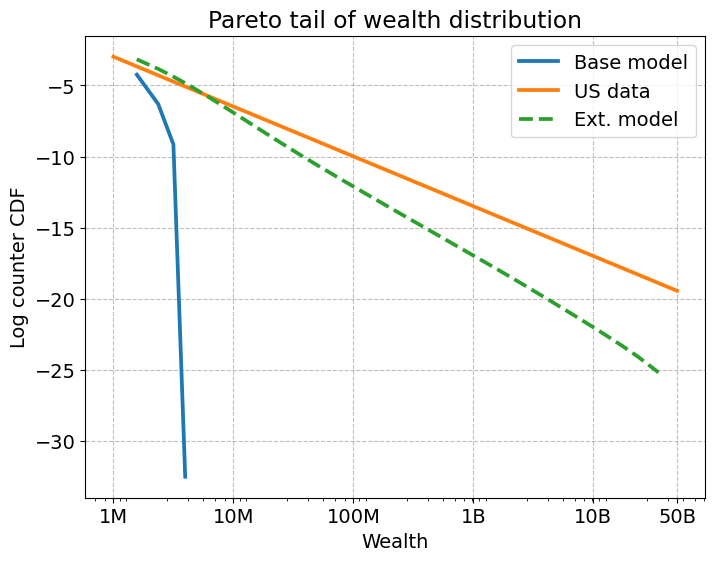

In [11]:
def get_pareto_dist(model):

    # Plot against US data from GKKOC 2023 
    fac = 1000
    xmin_GKKOC = (1_000_000/fac) / (90000/fac) 
    xmax_GKKOC = (5000_000_000/fac) / (90000/fac )

    ss = model.ss 
    xmin = ss.L*ss.w * xmin_GKKOC
    xmax = ss.L*ss.w * xmax_GKKOC

    a = ss.a 
    D = ss.D 
    a_avg = np.sum(D*a,axis=(0,1)) / np.sum(D,axis=(0,1))
    D_avg = np.sum(D,axis=(0,1))
    CDF_avg = 1 - np.cumsum(D_avg)

    a_plot = a_avg[a_avg > xmin]
    D_plot = np.log(CDF_avg[a_avg > xmin])

    # data from GKKOC 2023 
    data_labels = np.array([1, 10, 100, 1000, 10000, 50000])
    custom_ticks = (1_000_000/fac)*data_labels/ (90000/fac) * ss.L*ss.w
    custom_labels = ['1M', '10M', '100M', '1B', '10B', '50B']

    a_data = np.linspace(custom_ticks[0],custom_ticks[-1],1000)
    D_US = np.log(a_data**(-1.52))

    return dict(a_plot=a_plot, D_plot=D_plot, custom_ticks=custom_ticks, custom_labels=custom_labels,
                a_data=a_data,D_US=D_US)

# Set the ticks and corresponding labels on the x-axis
pareto_base = get_pareto_dist(model_base)
pareto_r = get_pareto_dist(model)


# Create the plot
fig1, ax1 = plt.subplots(figsize=(8, 6))


ax1.plot(pareto_base['a_plot'], pareto_base['D_plot'], label="Base model", lw=2.7)
ax1.plot(pareto_r['a_data'], pareto_r['D_US'], label="US data", lw=2.7)
ax1.plot(pareto_r['a_plot'], pareto_r['D_plot'], label="Ext. model", ls='--', lw=2.7)

# Set the x-axis to a logarithmic scale
ax1.set_xscale('log')
ax1.set_xticks(pareto_r['custom_ticks'], labels=pareto_r['custom_labels'])
ax1.set_xlabel("Wealth")
ax1.set_ylabel("Log counter CDF")
ax1.set_title("Pareto tail of wealth distribution")
ax1.legend()
plt.show()